The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0


# Deep Recurrent Neural Networks

:label:`sec_deep_rnn`

Up until now, we have focused on defining networks 
consisting of a sequence input, 
a single hidden RNN layer,
and an output layer. 
Despite having just one hidden layer 
between the input at any time step
and the corresponding output,
there is a sense in which these networks are deep.
Inputs from the first time step can influence
the outputs at the final time step $T$ 
(often 100s or 1000s of steps later).
These inputs pass through $T$ applications
of the recurrent layer before reaching 
the final output. 
However, we often also wish to retain the ability
to express complex relationships 
between the inputs at a given time step
and the outputs at that same time step.
Thus we often construct RNNs that are deep
not only in the time direction 
but also in the input-to-output direction.
This is precisely the notion of depth
that we have already encountered 
in our development of MLPs
and deep CNNs.


The standard method for building this sort of deep RNN 
is strikingly simple: we stack the RNNs on top of each other. 
Given a sequence of length $T$, the first RNN produces 
a sequence of outputs, also of length $T$.
These, in turn, constitute the inputs to the next RNN layer. 
In this short section, we illustrate this design pattern
and present a simple example for how to code up such stacked RNNs.
Below, in :numref:`fig_deep_rnn`, we illustrate
a deep RNN with $L$ hidden layers.
Each hidden state operates on a sequential input
and produces a sequential output.
Moreover, any RNN cell (white box in :numref:`fig_deep_rnn`) at each time step
depends on both the same layer's 
value at the previous time step
and the previous layer's value 
at the same time step. 

![Architecture of a deep RNN.](../img/deep-rnn.svg)
:label:`fig_deep_rnn`

Formally, suppose that we have a minibatch input
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 
(number of examples: $n$, number of inputs in each example: $d$) at time step $t$.
At the same time step, 
let the hidden state of the $l^\mathrm{th}$ hidden layer ($l=1,\ldots,L$) be $\mathbf{H}_t^{(l)} \in \mathbb{R}^{n \times h}$ 
(number of hidden units: $h$)
and the output layer variable be 
$\mathbf{O}_t \in \mathbb{R}^{n \times q}$ 
(number of outputs: $q$).
Setting $\mathbf{H}_t^{(0)} = \mathbf{X}_t$,
the hidden state of
the $l^\mathrm{th}$ hidden layer
that uses the activation function $\phi_l$
is calculated as follows:

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}),$$
:eqlabel:`eq_deep_rnn_H`

where the weights $\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$ and $\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$, together with
the bias $\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$, 
are the model parameters of the $l^\mathrm{th}$ hidden layer.

In the end, the calculation of the output layer 
is only based on the hidden state 
of the final $L^\mathrm{th}$ hidden layer:

$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q,$$

where the weight $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ 
and the bias $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ 
are the model parameters of the output layer.

Just as with MLPs, the number of hidden layers $L$ 
and the number of hidden units $h$ are hyperparameters
that we can tune.
Common RNN layer widths ($h$) are in the range $(64, 2056)$,
and common depths ($L$) are in the range $(1, 8)$. 
In addition, we can easily get a deep gated RNN
by replacing the hidden state computation in :eqref:`eq_deep_rnn_H`
with that from an LSTM or a GRU.


In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

## Implementation from Scratch

To implement a multi-layer RNN from scratch,
we can treat each layer as an `RNNScratch` instance
with its own learnable parameters.


In [2]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = [d2l.RNNScratch(num_inputs if i==0 else num_hiddens,
                                    num_hiddens, sigma)
                     for i in range(num_layers)]

The multi-layer forward computation
simply performs forward computation
layer by layer.


In [3]:
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None: Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = tf.stack(outputs, 0)
    return outputs, Hs

As an example, we train a deep GRU model on
*The Time Machine* dataset (same as in :numref:`sec_rnn-scratch`).
To keep things simple we set the number of layers to 2.


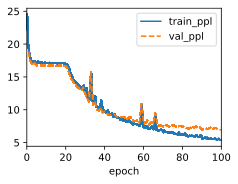

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
with d2l.try_gpu():
    rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)
    model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

## Concise Implementation


Fortunately many of the logistical details required
to implement multiple layers of an RNN 
are readily available in high-level APIs.
Our concise implementation will use such built-in functionalities.
The code generalizes the one we used previously in :numref:`sec_gru`,
allowing specification of the number of layers explicitly 
rather than picking the default of a single layer.


In [5]:
class GRU(d2l.RNN):  #@save
    """The multi-layer GRU model."""
    def __init__(self, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        gru_cells = [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
                     for _ in range(num_layers)]
        self.rnn = tf.keras.layers.RNN(gru_cells, return_sequences=True,
                                       return_state=True, time_major=True)

    def forward(self, X, state=None):
        outputs, *state = self.rnn(X, state)
        return outputs, state

The architectural decisions such as choosing hyperparameters 
are very similar to those of :numref:`sec_gru`.
We pick the same number of inputs and outputs 
as we have distinct tokens, i.e., `vocab_size`.
The number of hidden units is still 32.
The only difference is that we now 
(**select a nontrivial number of hidden layers 
by specifying the value of `num_layers`.**)


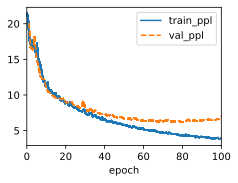

In [6]:
gru = GRU(num_hiddens=32, num_layers=2)
with d2l.try_gpu():
    model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [7]:
model.predict('it has', 20, data.vocab)

'it has and the time travel'

## Summary

In deep RNNs, the hidden state information is passed 
to the next time step of the current layer 
and the current time step of the next layer.
There exist many different flavors of deep RNNs, such as LSTMs, GRUs, or vanilla RNNs. 
Conveniently, these models are all available 
as parts of the high-level APIs of deep learning frameworks.
Initialization of models requires care. 
Overall, deep RNNs require considerable amount of work 
(such as learning rate and clipping) 
to ensure proper convergence.

## Exercises

1. Replace the GRU by an LSTM and compare the accuracy and training speed.
1. Increase the training data to include multiple books. How low can you go on the perplexity scale?
1. Would you want to combine sources of different authors when modeling text? Why is this a good idea? What could go wrong?


[Discussions](https://discuss.d2l.ai/t/3862)
